##### IFB Virtual Machine Configuration

* `rootDir` points to Jupyter Home Directory
* `projectDir` points to the Git project, holds the *tsv* file
* `libDir` points to Git project python library with files names `go.py  stat_utils.py  uniprot.py`
* `dataDir` points to shared data folder with uniprot and GO files

In [1]:
import sys

rootDir = "//ifb/data/mydatalocal"
projectDir = rootDir + "/VDBscratch"
libDir = projectDir + "/lib"
dataDir= "/ifb/data/public/teachdata/m2binf_ucbl/data" 

sys.path.append(libDir)

In [2]:
import pandas, uniprot, go
import numpy as np
from stat_utils import computeORA_BKG

#%load_ext autoreload
#%autoreload 2

In [3]:
%matplotlib nbagg
import matplotlib.pyplot as plt

## Jeux de données
* Experimental dataset as TSV
* Go ontology as [owl](http://www.obofoundry.org/ontology/go.html)
* Uniprot entries as XML files

## Objectifs
1. Lire et traiter des données d'entrée avec [PANDAS](https://pandas.pydata.org/)

2. Représenter la distribution empirique des "fold-change" (**FC**)

3. Evaluer un seuil de **FDR** 5%, with normal approximation
    1. Proposer une function qui à un seuil de faux-positif retourne une valeur de **FDC**
    2. Proposer une fonction qui appelle la précedente et retourne, en plus, une représentation graphique

4. Analyse de l'enrichissement en pathway Gene Ontology
    1. Arbre des termes d'ontologie.
        * Visualisation de l'arbre complet
    2. Modélisation hypergéometrique des fréquence attendues des termes GO
        * Les protéines très abondantes présentent-elles des termes GO en quantité remarquable ?
        * Les protéines peu abondantes présentent-elles des termes GO en quantité remarquable ?
    3. Visualisation de l'arbre avec style des noeuds rendant compte des protéines qu'ils annotent
 
5. Volcano plot
    1. Scatter-Plot **FC** vs **LOG10 Adj.P-val**
    2. Colorer les protéines très/peu abondantes
    3. ipyWidget slider FDR permettant de changer les seuils "d'abondance" 
    
6. Volcano Plot présentant les pathways
    1. ipyWidget Slider
    2. Coloration des points pour les protéines annotées par ce pathway 

## Conclusion
* Compare wt/mutant conditions


## Ressources
https://www.bioconductor.org/help/course-materials/2015/SeattleApr2015/E_GeneSetEnrichment.html

https://matplotlib.org/gallery.html#




## Format des données expérimentales

Le terme *SA*, désigne le ratio de (**S**ur) **A**bondance pour une protéines entre deux experiences.
Les valeurs de **SA** sont stockées dans la colonne ```Log2 Corrected Abundance Ratio```. Un "ratio" négatif indique qu'une protéine est moins présente dans l'experience considéré par rapport à une experience de référence.

* La condition experimentale de référence est un milieu de croissance bactérienne
* La condition experimentale testée est un milieu riche en Tétracycline 



# Première exploration des données

### Lecture des valeurs experimentales
Charger ```TCL_wt1.tsv``` dans une [dataframe pandas](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html).
* Retirer les lignes présentant des aberrations numériques

##### [Comment filtrer des lignes Pandas](https://cmdlinetips.com/2018/02/how-to-subset-pandas-dataframe-based-on-values-of-a-column/)

In [ ]:
### Cellule Exercice

### Visualisation de la distribution empirique
Représenter la distribution des **SA** de l'experience.
* [matplotlib histogramme](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.hist.html)
* Réaliser un grid plot avec 4 histogrammes présentant chacun un nombre de catégories différent.
* Créer la fonction qui produit l'histogramme à partir d'une DataFrame pandas. 
```python 
    def empirical(data:pandas.Series, bins:Number) -> (fig,ax, bars)
```
* Cete fonction retourne les objets figure et Axes et les valeurs des catégories de l'histogramme. 
##### [API des colonnes pandas](https://pandas.pydata.org/pandas-docs/version/0.24/reference/series.html)

#### Pour aller plus loin
Réaliser une Kernel Density Estimation sur un histogramme matplotlib doit être fait à l'aide du package scipy.
Heureusement le package seaborn propose une macro pour cela.

`seaborn.kdeplot(np.array(data), bw=0.5)`
* implémenter ce graphique dans une fonction 
```python 
    def empiricalKDE(data:pandas.Series, bins:Number, bandwidth:Number) -> (fig,ax)
```

In [ ]:
### Cellule Exercice

### Distribution théorique attendue
Entre deux experiences, les quantités d'une protéine non affectée par le changement de conditions devraient-elles être strictement identiques ?

Proposer une distribution théorique des **SA** des protéines **non affectées** par le changement de conditions.
 * Calculer les paramètres de cette distribution à partir de l'échantillon
 * Représenter ces paramètres par des lignes verticales sur l'histogramme précedent

Implémenter une fonction qui prend un échantillon et **dessine** la distribution théorique et empirique. Elle utilisera la fonction ```empirical()```

```python 
    def empiricalAndTheoric(data:pandas.Series)
```

## Example pour démarrer
Superposition de la distrubtion empirique et de la densité théorique d'une gaussienne

<IPython.core.display.Javascript object>


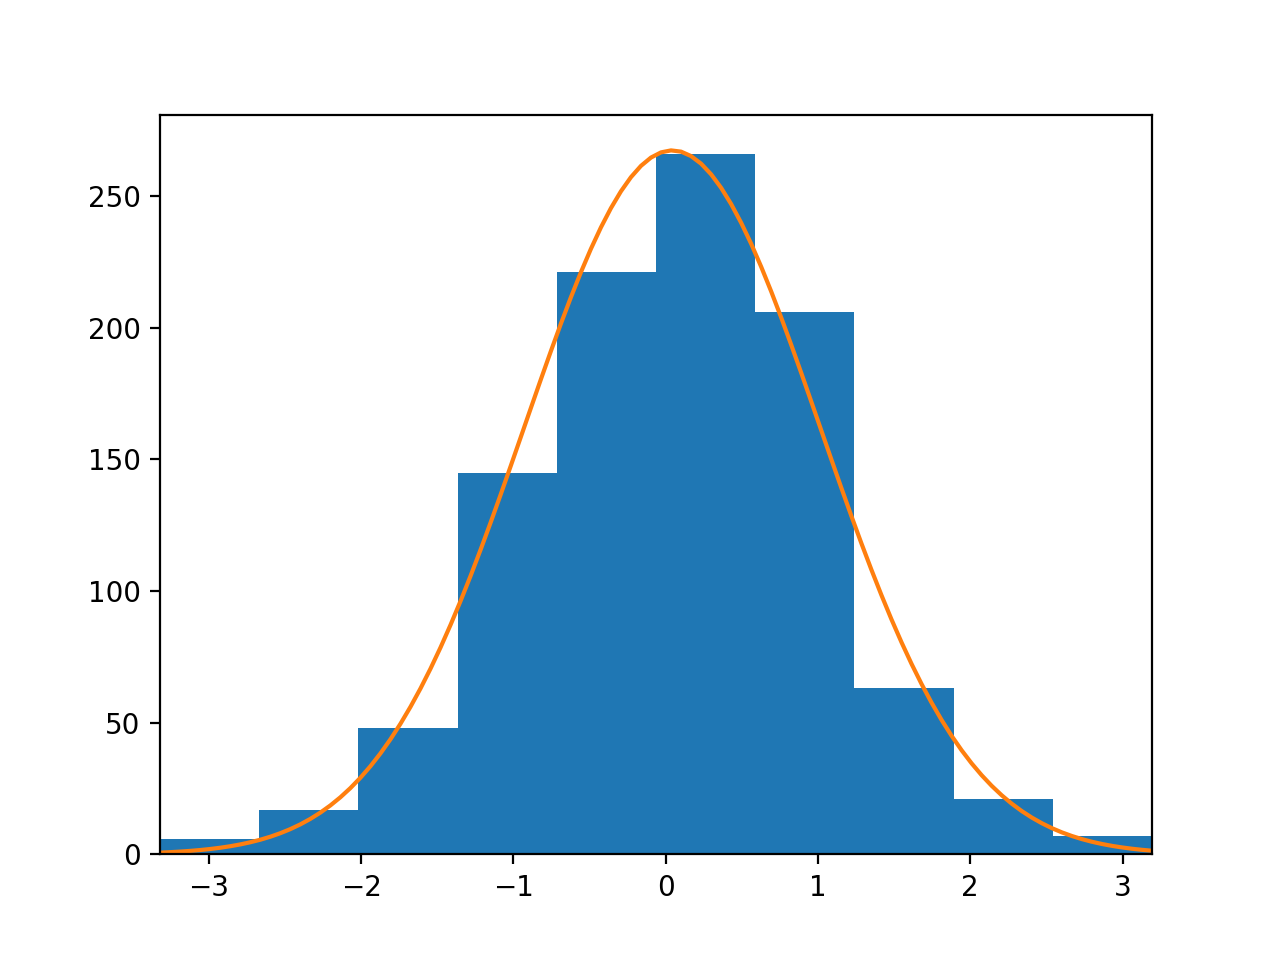

The array returned by plt.hist holds histogramme coordinates
(array([  6.,  17.,  48., 145., 221., 266., 206.,  63.,  21.,   7.]), array([-3.32089013, -2.66947403, -2.01805793, -1.36664183, -0.71522573,
       -0.06380963,  0.58760647,  1.23902257,  1.89043867,  2.54185477,
        3.19327087]), <a list of 10 Patch objects>)


In [14]:
from scipy.stats import norm

arr = np.random.randn(1000)
fig, ax = plt.subplots()

result = plt.hist(arr)
plt.xlim((min(arr), max(arr)))

mean = np.mean(arr)
variance = np.var(arr)
sigma = np.sqrt(variance)
x = np.linspace(min(arr), max(arr), 100)
dx = result[1][1] - result[1][0]
scale = len(arr)*dx
plt.plot(x, norm.pdf(x, mean, sigma)*scale)
plt.show()

print(f"The array returned by plt.hist holds histogramme coordinates\n{result}")

In [ ]:
### Cellule Exercice

### Seuil de significativité
Comment déterminer un seuil de *SA* au delà duquel seulement 5% des protéines non affectées seraient selectionnées ?

Pour une Méthode de reconnaissance des protéines sur abondantes que siginifie ce taux de 5% ?

Implémenter une fonction qui prend un échantillon et un pourcentage en argument et retourne la valeur seuil correspondant à cet argument.

```python 
    def FDR_threshold(data:pandas.Series, t=0.05) # Où t peut valoir 5%, 2.5% ou 1%
```

Creer la fonction suivante

```python
def empiricalAndTheoricTreshold(data:pandas.Series, t=0.05)
```

Elle combinera les fonctions ```FDR_threshold``` et ```empiricalAndTheoric``` pour ajouter à son histogramme une ligne verticale rouge à l'emplacement du seuil.

Aide: L'inverse de la fonction de densité cumulée (aka: [percent-point-function](https://en.wikipedia.org/wiki/Quantile_function)) de la loi normale est [implémentée dans scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html) (**ppf**).



##### Visualisation des seuils et de la distribution empirique
Implémenter une fonction qui prend un échantillon et dessine la distribution théorique, empirique et colore [l'aire sous la courbe](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.fill_between.html) théorique au delà du seuil demandé.
Vous pourrez ajouter les légendes correspondant à $\mu, 2\sigma, \alpha$ 

```python 
    def empiricalAndTheoricThresholdArea(SA_list, parameters*)

```


*Exemple de figure à obtenir*
![caption](../figs/empiricalAndTheoricTresholdArea_GIMP.png)



In [ ]:
### Cellule Exercice

### Pour aller plus loin

###### La loi normale est un modèle contestable ici
https://en.wikipedia.org/wiki/Cauchy_distribution


#### Volcano Plot simple
Ce type de figure représente pour chaque protéine en abscisse le taux d'abondance et en ordonnées la précision de la mesure.
Réaliser les graphiques suivants.
![caption](../figs/volcano_simple.png)

In [ ]:
### Cellule Exercice